##IMPORTS

In [6]:
!pip install category_encoders
!pip install imbalanced-learn
!pip install dask dask-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 904.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.9/148.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00


In [21]:
import csv
import os
import sys
import pandas as pd
import pickle
import dask.dataframe as df
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import numpy as np
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
from csv import reader
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive
sns.set_style('whitegrid')
sns.set_palette('pastel')

In [8]:
# Mount Google Drive
drive.mount('/content/gdrive')
data_dir_train  = 'gdrive/My Drive/creditcard_data/fraudTrain.csv'
data_dir_test  = 'gdrive/My Drive/creditcard_data/fraudTest.csv'

Mounted at /content/gdrive


#INITIALIZE DASK DATAFRAMES

In [9]:
# Read CSV files into Dask DataFrames
train_df = df.read_csv(data_dir_train)
train_df = train_df.set_index('Unnamed: 0')
test_df = df.read_csv(data_dir_test)
test_df.set_index('Unnamed: 0')

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
npartitions=2,,,,,,,,,,,,,,,,,,,,,,
0,object,int64,object,object,float64,object,object,object,object,object,object,int64,float64,float64,int64,object,object,object,int64,float64,float64,int64
278054,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555718,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


#ANALYZE DATA

In [10]:
train_df.head(3)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


In [11]:
# Count the total number of missing values in the DataFrame
missing_values_count = train_df.isna().sum().sum().compute()
print("Total missing values:", missing_values_count)

Total missing values: 0


In [12]:
# Count the duplicate rows in the DataFrame
duplicate_rows_count = train_df.groupby(train_df.columns.tolist()).size().reset_index()

# Filter out rows with count > 1 to get duplicate rows
duplicate_rows = duplicate_rows_count[duplicate_rows_count[0] > 1]

# Count the total number of duplicate rows
total_duplicate_rows_count = len(duplicate_rows)

# Display the count of duplicate rows
print("Total count of duplicate rows:", total_duplicate_rows_count)

Total count of duplicate rows: 0


We can assume that each transaction is unique given that there are no duplicate rows

In [13]:
# Calculate value counts for "is_fraud" column
is_fraud = train_df["is_fraud"].value_counts()

# Trigger computation and retrieve results
is_fraud_result = is_fraud.compute()

# Print the counts
print("Yes:", is_fraud_result[1])
print("No:", is_fraud_result[0])

Yes: 7506
No: 1289169


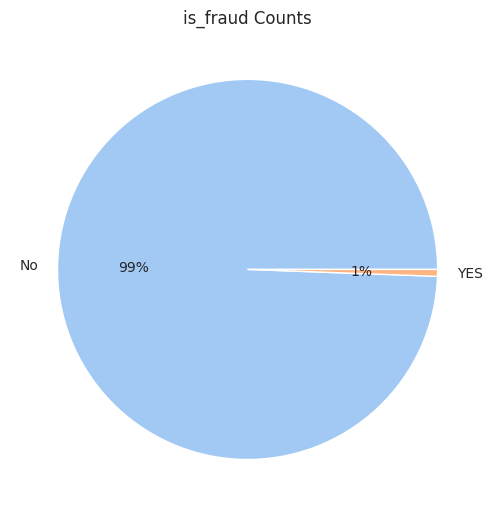

In [14]:
is_fraud = train_df["is_fraud"].value_counts()
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # Subplot for the pie chart
plt.pie(is_fraud, labels=["No", "YES"], autopct="%0.0f%%")
plt.title("is_fraud Counts")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

We observe that the dataset is unbalanced

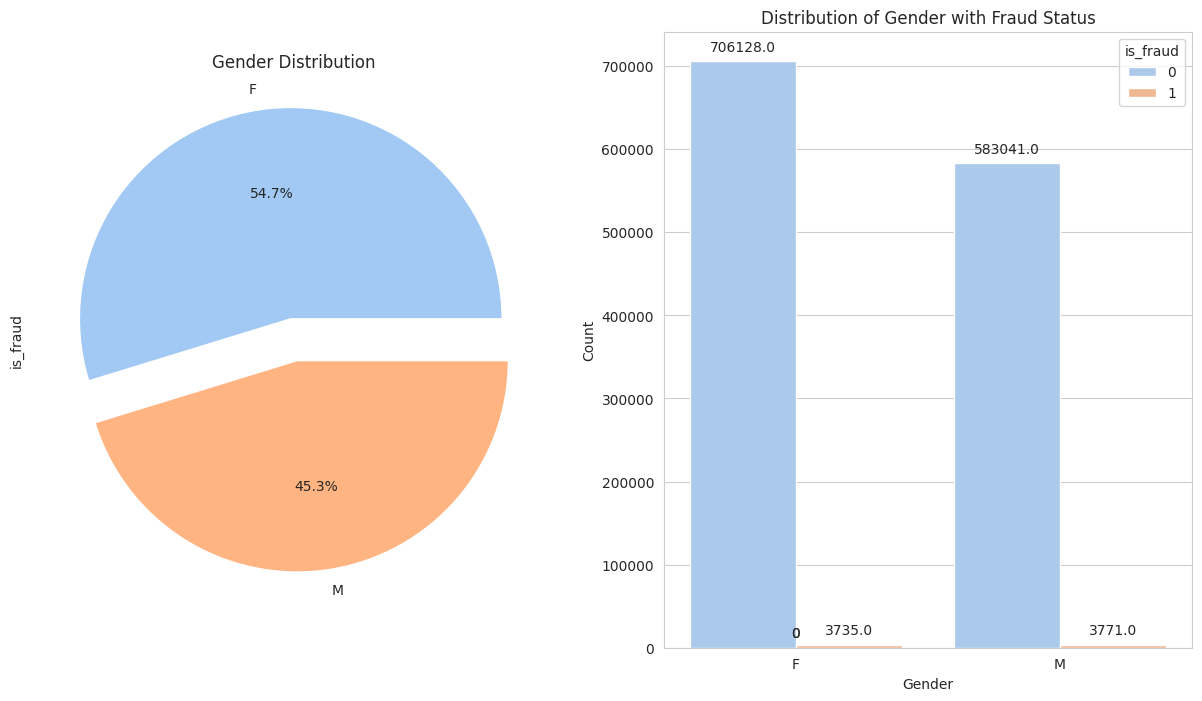

In [15]:
# Create subplots
fig, axb = plt.subplots(ncols=2, nrows=1, figsize=(15, 8))

# Gender Distribution Pie Chart
explode = [0.1, 0.1]
train_df.groupby('gender')['is_fraud'].count().compute().plot.pie(explode=explode, autopct="%1.1f%%", ax=axb[0])
axb[0].set_title("Gender Distribution")

# Gender Distribution Count Plot
ax = sns.countplot(x="gender", hue="is_fraud", data=train_df.compute(), ax=axb[1])

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
axb[1].set_title("Distribution of Gender with Fraud Status")
axb[1].set_xlabel("Gender")
axb[1].set_ylabel("Count")

# Show the plot
plt.show()

Females make more transactions however commit less fraudulent transactions when compared to males

#FEATURE ENGINEERING

In [16]:
# Change date type from object to datetime
train_df['trans_date_trans_time'] = df.to_datetime(train_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')
test_df['trans_date_trans_time'] = df.to_datetime(test_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

In [17]:
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour
test_df['hour'] = test_df['trans_date_trans_time'].dt.hour

train_df['month'] = train_df['trans_date_trans_time'].dt.month
test_df['month'] = test_df['trans_date_trans_time'].dt.month

train_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,month
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1


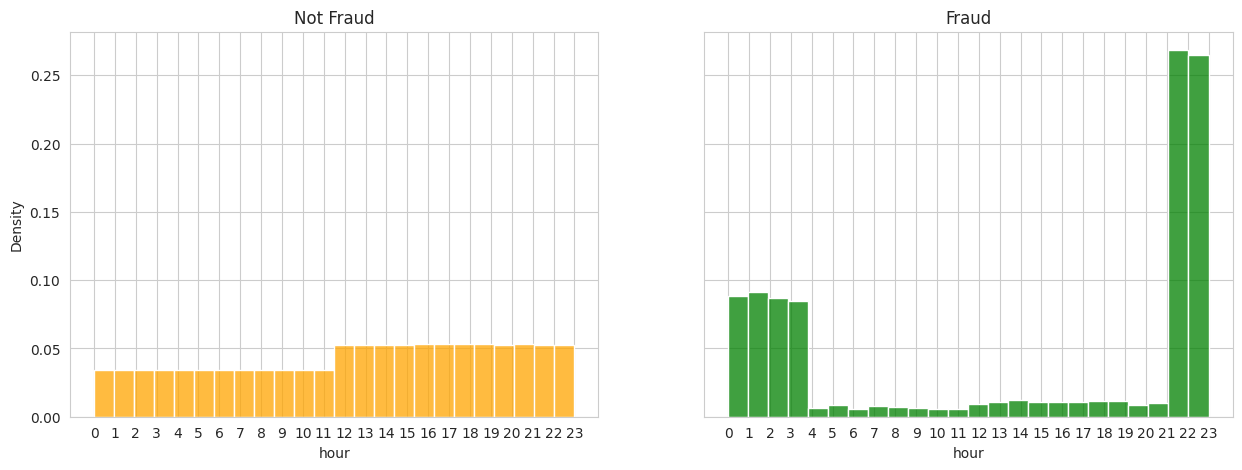

In [22]:
# Convert Dask DataFrame to Pandas DataFrame for plotting
train_df_pd = train_df.compute()

# Create subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)

# Plot histogram for non-fraud transactions
sns.histplot(x='hour', data=train_df_pd[train_df_pd["is_fraud"] == 0],
             stat="density", bins=24, ax=ax1, color="orange")
ax1.set_title("Not Fraud")
ax1.set_xticks(np.arange(24))  # ticks of the day 0 -> 23

# Plot histogram for fraud transactions
sns.histplot(x='hour', data=train_df_pd[train_df_pd["is_fraud"] == 1],
             stat="density", bins=24, ax=ax2, color="green")
ax2.set_title("Fraud")
ax2.set_xticks(np.arange(24))  # ticks of the day 0 -> 23

plt.show()

We observe that fraudulent transactions more often occur during the last 2 hours of the day

###**DATA PREPROCESSING**

Data preprocessing includes removing irrelevant columns from the dataset to reduce noise and improve model performance. This step focuses on retaining only the features that are relevant and informative for the machine learning task at hand. Removing unhelpful columns streamlines the data and enhances the model's ability to learn meaningful patterns.

In [23]:
# remove non-useful columns
columns_to_drop = ['first', 'unix_time', 'dob', 'cc_num', 'zip', 'city','street', 'state', 'trans_num', 'trans_date_trans_time']
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)
train_df.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
Unnamed: 0,,,,,,,,,,,,,,
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,Banks,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,0,1
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Gill,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,0,1


In [24]:
# #clean merchant column
# train_df['merchant'] = train_df['merchant'].apply(lambda x : x.replace('fraud_',''))

# Define a function to clean the 'merchant' column
def clean_merchant(x):
    return x.str.replace('fraud_', '')

# Define the meta parameter with the expected output type
meta = ('merchant', 'object')

# Apply the cleaning function to the 'merchant' column
train_df['merchant'] = train_df['merchant'].map_partitions(clean_merchant, meta=meta)

# Persist the changes
train_df = train_df.persist()

In [25]:
train_df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 14 entries, merchant to month
dtypes: object(5), float64(5), int64(4)

In [26]:
train_df.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
Unnamed: 0,,,,,,,,,,,,,,
0,"Rippin, Kub and Mann",misc_net,4.97,Banks,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,0,1
1,"Heller, Gutmann and Zieme",grocery_pos,107.23,Gill,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,0,1


###**DATA ENCODING**

Perform categorical variable encoding using scikit-learn's LabelEncoder. It encodes categorical variables to numerical values for both training and testing data. The encoded encoders are saved using pickle. The purpose is to prepare categorical data for machine learning models, as many algorithms require numerical input.









In [27]:
def encode_partition(partition):
    encoder = LabelEncoder()
    partition = partition.fillna('missing')  # Fill missing values if any
    for col in partition.columns:
        if pd.api.types.is_string_dtype(partition[col]):
            partition[col] = encoder.fit_transform(partition[col])
    return partition

def encode(df):
    encoders = {}
    encoded_df = df.map_partitions(encode_partition)
    with open('LE_mdl_v1.pkl', 'wb') as f:
        pickle.dump(encoders, f)
    return encoded_df

train = encode(train_df)
test = encode(test_df)

In [28]:
train.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
Unnamed: 0,,,,,,,,,,,,,,
0,514,8,4.97,18,0,36.0788,-81.1781,3495,360,36.011293,-82.048315,0,0,1
1,241,4,107.23,155,0,48.8878,-118.2105,149,416,49.159047,-118.186462,0,0,1


##DEFINITION OF TRAINING SET

###UNDER SAMPLING###

Due to the imbalance in our dataset, we explore under-sampling by reducing the number of samples in the majority class. We randomly select a subset of the majority class samples to match the size of the minority class.

In [29]:
# Sample equal number of rows for each value of is_fraud
fraud_1_sampled = train[train['is_fraud'] == 1].sample(frac=7506/7506, random_state=42)
fraud_0_sampled = train[train['is_fraud'] == 0].sample(frac=7506/1289169, random_state=42)

# Concatenate the sampled groups
train_downsampled_df = df.concat([fraud_1_sampled, fraud_0_sampled])


In [30]:
# Calculate value counts for "is_fraud" column
is_fraud_downsampled = train_downsampled_df["is_fraud"].value_counts()

# Trigger computation and retrieve results
is_fraud_result_downsampled = is_fraud_downsampled.compute()

# Print the counts
print("Yes:", is_fraud_result_downsampled[1])
print("No:", is_fraud_result_downsampled[0])

Yes: 7506
No: 7506


###OVER SAMPLING###

We also explore oversampling using SMOTE to create synthetic samples for the minority class by generating new instances by interpolating between existing minority class samples.

0    1289169
1    1289169
Name: is_fraud, dtype: int64

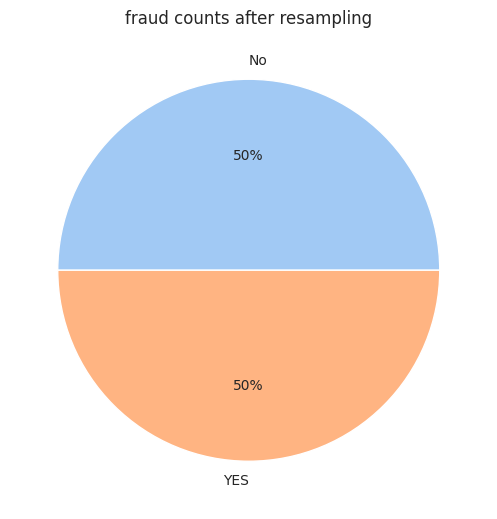

In [31]:
df_no_fraud = train.drop('is_fraud', axis=1)
df_fraud= train['is_fraud']
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(df_no_fraud, df_fraud)

df_X = pd.DataFrame(X, columns=df_no_fraud.columns)
df_y= pd.DataFrame(y, columns=['is_fraud'])
concat_df = pd.concat([df_X, df_y], axis=1)
train_oversampled_df = df.from_pandas(concat_df, npartitions=10)

oversampled_is_fraud = train_oversampled_df["is_fraud"].value_counts()
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.pie(oversampled_is_fraud, labels=["No", "YES"], autopct="%0.0f%%")
plt.title("fraud counts after resampling")
plt.tight_layout()

train_oversampled_df["is_fraud"].value_counts().compute()

#MODEL TRAINING

We train three models Logistics Regression Model, Random Forest Model, and XGBoost Model with Undersampled and Oversampled datasets.

In [32]:
def train_and_evaluate_model(train_df, test_df, target_column, model, model_filename, **hyperparameters):
    # Drop 'Unnamed: 0' column if it exists in train and test dataframes
    if 'Unnamed: 0' in train_df.columns:
        train_df = train_df.drop(columns=['Unnamed: 0'])
    if 'Unnamed: 0' in test_df.columns:
        test_df = test_df.drop(columns=['Unnamed: 0'])

    # Split the training data into features and target
    X_train = train_df.drop(target_column, axis=1)
    y_train = train_df[target_column]

    # Instantiate the logistic regression model
    model = model(**hyperparameters)

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Save the trained model
    joblib.dump(model, model_filename+".joblib")

    # Split the test data into features and target
    X_test = test_df.drop(target_column, axis=1)
    y_test = test_df[target_column]

    # Predict on the test set
    y_pred = model.predict(X_test)

    return y_test, y_pred

def get_model_eval_reports(y_test, y_pred):
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Print the classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

##Undersampled Data Model Training

In [33]:
## Training Logistics Regression Model with Undersampled and Oversampled datasets
hyperparameters = {'max_iter': 10000}
lr_us_y_test, lr_us_y_pred = train_and_evaluate_model(train_downsampled_df, test, 'is_fraud', LogisticRegression, 'LogisticRegressionUndersampled', **hyperparameters)

In [34]:
## Training Random Forest Model with Undersampled dataset
hyperparameters = {'n_estimators': 100, 'random_state': 42}
rf_us_y_test, rf_us_y_pred = train_and_evaluate_model(train_downsampled_df, test, 'is_fraud', RandomForestClassifier, 'RandomForestClassifierUndersampled', **hyperparameters)

In [35]:
## Training XGBoost Model with Undersampled dataset
hyperparameters = {'use_label_encoder': False, 'eval_metric': 'logloss'}
xg_us_y_test, xg_us_y_pred = train_and_evaluate_model(train_downsampled_df, test, 'is_fraud', XGBClassifier, 'XGBClassifierUndersampled', **hyperparameters)

##Oversampled Data Model Training

In [36]:
"""
Information:
Random Forest model training takes a significant amount of time.
"""

hyperparameters = {"max_iter": 10000}
logestic_regression_test, logestic_regression_predection = train_and_evaluate_model(train_oversampled_df, test, "is_fraud", LogisticRegression, "LogisticRegressionOversampled", **hyperparameters)

"""
hyperparameters = {"n_estimators": 100, "random_state": 42}
random_forest_test, random_forest_predection = train_and_evaluate_model(train_oversampled_df, test, "is_fraud", RandomForestClassifier, "RandomForestOversampled", **hyperparameters)
"""

hyperparameters = {"use_label_encoder": False, "eval_metric": "logloss"}
xgboost_test, xgboost_predection = train_and_evaluate_model(train_oversampled_df, test, "is_fraud", XGBClassifier, "XgbOversampled", **hyperparameters)

#FINETUNING MODEL

We train and evaluate our machine learning models using grid search cross-validation. The function takes training and test dataframes, target column, a machine learning model, its filename for saving, a parameter grid for grid search, and optional cross-validation folds.

In [37]:
def train_with_multiple_params(train_df_passed, test_df_passed, target_column, model, model_filename, param_grid, cv=5):

    if isinstance(train_df_passed, pd.DataFrame):
        train_df = train_df_passed
    else:
        train_df = train_df_passed.compute()

    if isinstance(test_df_passed, pd.DataFrame):
        test_df = test_df_passed
    else:
        test_df = test_df_passed.compute()

    # Drop 'Unnamed: 0' column if it exists in train and test dataframes
    if 'Unnamed: 0' in train_df.columns:
        train_df = train_df.drop(columns=['Unnamed: 0'])
    if 'Unnamed: 0' in test_df.columns:
        test_df = test_df.drop(columns=['Unnamed: 0'])

    # Split the training data into features and target
    X_train = train_df.drop(target_column, axis=1)
    y_train = train_df[target_column]

    # Instantiate the model
    model_instance = model()

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(model_instance, param_grid, cv=cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Save the trained model
    # joblib.dump(best_model, model_filename+".joblib")

    # Print parameters passed for the best model
    print("Parameters passed for the best model:")
    print(grid_search.best_params_)

    # Split the test data into features and target
    X_test = test_df.drop(target_column, axis=1)
    y_test = test_df[target_column]

    # Predict on the test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{best_model.__class__.__name__} Accuracy:", accuracy)

    # Print the classification report
    print(f"{best_model.__class__.__name__} Classification Report:")
    print(classification_report(y_test, y_pred))

    return y_test, y_pred

In [38]:
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'max_iter': [100, 500, 1000]
}

train_with_multiple_params(train_downsampled_df, test, 'is_fraud', LogisticRegression, 'logistic_regression_model', param_grid)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Parameters passed for the best model:
{'C': 1.0, 'max_iter': 500}
LogisticRegression Accuracy: 0.9498127650845122
LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    553574
           1       0.06      0.75      0.10      2145

    accuracy                           0.95    555719
   macro avg       0.53      0.85      0.54    555719
weighted avg       1.00      0.95      0.97    555719



(0         0
 1         0
 2         0
 3         0
 4         0
          ..
 277660    0
 277661    0
 277662    0
 277663    0
 277664    0
 Name: is_fraud, Length: 555719, dtype: int64,
 array([0, 0, 0, ..., 0, 0, 0]))

In [39]:
# Define param_grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

train_with_multiple_params(train_downsampled_df, test, 'is_fraud', RandomForestClassifier, 'random_forest_model', param_grid_rf)

Parameters passed for the best model:
{'max_depth': 15, 'n_estimators': 300}
RandomForestClassifier Accuracy: 0.9729179675339515
RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    553574
           1       0.12      0.95      0.21      2145

    accuracy                           0.97    555719
   macro avg       0.56      0.96      0.60    555719
weighted avg       1.00      0.97      0.98    555719



(0         0
 1         0
 2         0
 3         0
 4         0
          ..
 277660    0
 277661    0
 277662    0
 277663    0
 277664    0
 Name: is_fraud, Length: 555719, dtype: int64,
 array([0, 0, 0, ..., 0, 1, 0]))

In [40]:
# Define param_grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

train_with_multiple_params(train_downsampled_df, test, 'is_fraud', XGBClassifier, 'XGBoost_model', param_grid_xgb)

Parameters passed for the best model:
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
XGBClassifier Accuracy: 0.9764431304310272
XGBClassifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.14      0.96      0.24      2145

    accuracy                           0.98    555719
   macro avg       0.57      0.97      0.61    555719
weighted avg       1.00      0.98      0.99    555719



(0         0
 1         0
 2         0
 3         0
 4         0
          ..
 277660    0
 277661    0
 277662    0
 277663    0
 277664    0
 Name: is_fraud, Length: 555719, dtype: int64,
 array([0, 0, 0, ..., 0, 1, 0]))

#EVALUATION METRICS VISUALIZATION

In [41]:
def get_model_metrics(y_test_list, y_pred_list, labels):
    accuracy_scores = [accuracy_score(y_test, y_pred) for y_test, y_pred in zip(y_test_list, y_pred_list)]
    precision_scores = [precision_score(y_test, y_pred) for y_test, y_pred in zip(y_test_list, y_pred_list)]
    recall_scores = [recall_score(y_test, y_pred) for y_test, y_pred in zip(y_test_list, y_pred_list)]
    f1_scores = [f1_score(y_test, y_pred) for y_test, y_pred in zip(y_test_list, y_pred_list)]

    metrics_dict = {
        'Accuracy': accuracy_scores,
        'Precision': precision_scores,
        'Recall': recall_scores,
        'F1-score': f1_scores
    }
    return metrics_dict

In [47]:
def plot_graphs(metrics_dict):
    # Define colors if not provided

    # Plotting bar graphs for each metric
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    axs = axs.ravel()

    for idx, (metric, scores) in enumerate(metrics_dict.items()):
        axs[idx].bar(labels, scores)
        axs[idx].set_xlabel('Test Samples')
        axs[idx].set_ylabel(metric)
        axs[idx].set_title(f'{metric} vs Test Samples')
        axs[idx].grid(True)

    plt.show()

##Undersampled Data Model Evaluation

We evaluate the metrics of our undersampled data using
accuracy, precision, recall and f1 as the metrucs

In [43]:
y_test_list = [lr_us_y_test, rf_us_y_test, xg_us_y_test]
y_pred_list = [lr_us_y_pred, rf_us_y_pred, xg_us_y_pred]
labels = ['LogisticRegression', 'RandomForest', 'XGBoost']  # Labels for each test case

metrics_dict = get_model_metrics(y_test_list, y_pred_list, labels)

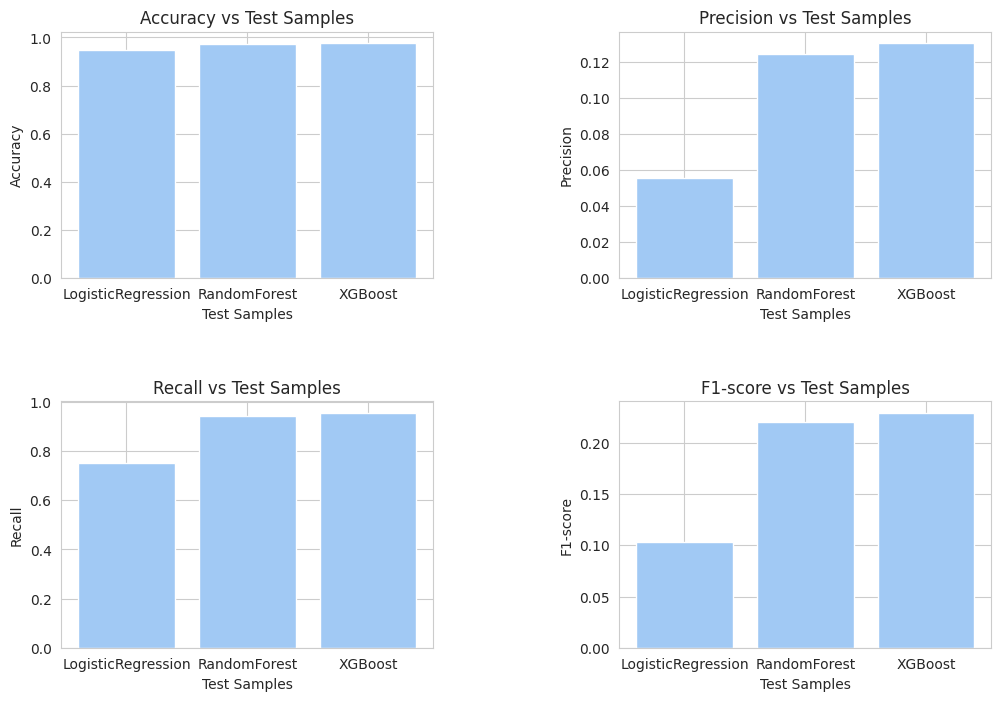

In [48]:
plot_graphs(metrics_dict)

##Oversampled Data Model Evaluation

We evaluate the metrics of our oversampled data using
accuracy, precision, recall and f1 as the metrucs for evaluating the model of the oversampled data.

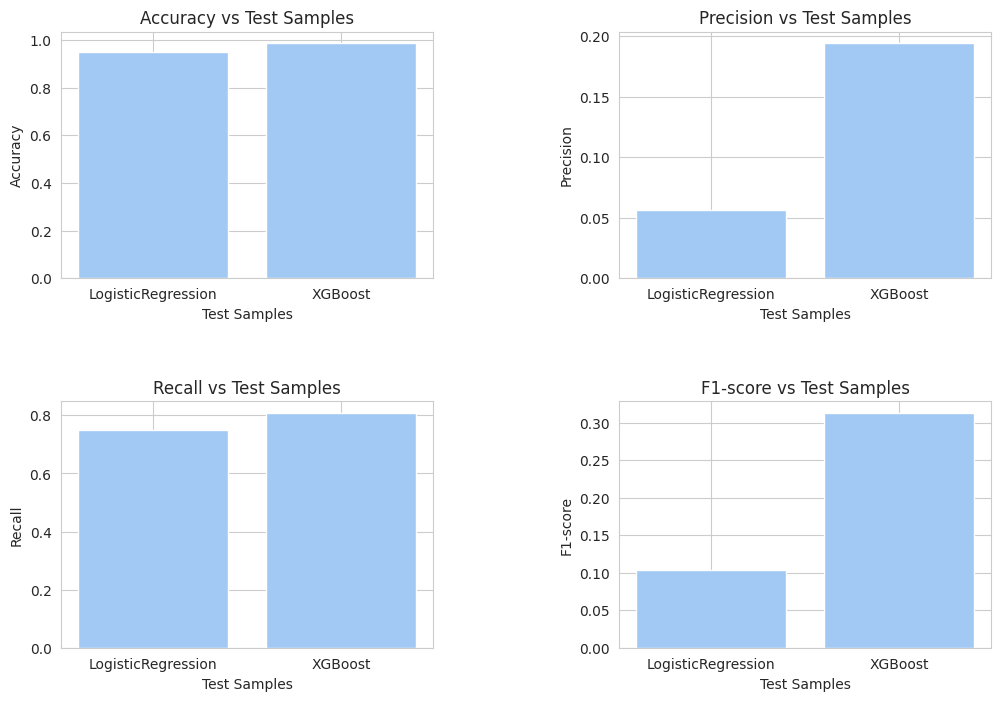

In [49]:
"""
Only the Logestic regression and the XGB boost model are evaluated, because
the Random Forest model of the oversampled data takes a very long time to
train
"""

y_test_list = [logestic_regression_test, xgboost_test]
y_pred_list = [logestic_regression_predection, xgboost_predection]
labels = ['LogisticRegression', 'XGBoost']

metrics_dict = get_model_metrics(y_test_list, y_pred_list, labels)
plot_graphs(metrics_dict)